In [1]:
# !pip install timm
# !pip install albumentations
# !pip install --force-reinstall albumentations
# !pip install segmentation_models_pytorch
# !pip install monai
# !pip install imageio
# !pip install pydicom
# !pip install pandas
# !pip install nibabel
# !pip install matplotlib
# !pip install torch
# !pip install cv
# !pip install pylibjpeg==1.4.0
# !pip install python_gdcm==3.0.17.1
# !pip install pylibjpeg-libjpeg


In [2]:
# !pip install -q kaggle
# !mkdir -p ./kaggle
# !cp kaggle.json ./kaggle/
# !chmod 600 ./kaggle/kaggle.json
# !cat ./kaggle/kaggle.json
# ! kaggle datasets list
# !kaggle datasets download -d haqishen/rsna-cropped-2d-224-0920-2m

In [3]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models


%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2>Config</h2>

In [4]:
DEBUG = False
kernel_type = '0920_2d_lstmv22headv2_vgg_224_15_6ch_8flip_augv2_drl3_rov1p2_rov3p2_bs4_lr6e5_eta6e6_lw151_50ep'
load_kernel = None
load_last = True

n_folds = 5
backbone = 'vgg16'

image_size = 224
n_slice_per_c = 15
in_chans = 6

init_lr = 23e-6
eta_min = 23e-6
lw = [15, 1]
batch_size = 2
drop_rate = 0.
drop_rate_last = 0.3
drop_path_rate = 0.
p_mixup = 0.5
p_rand_order = 0.2
p_rand_order_v1 = 0.2

data_dir = './Dataset/lstm_dataset/cropped_2d_224_15_ext0_5ch_0920_2m/cropped'
use_amp = True
num_workers = 8
out_dim = 1

n_epochs = 10

log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)






In [5]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.RandomBrightnessContrast(limit=0.1, p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=4, p=0.7),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=3),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.5),

    albumentations.CoarseDropout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/opt/conda/lib/python3.11/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'limit' is not valid and will be ignored.
  warn(
/opt/conda/lib/python3.11/site-packages/albumentations/augmentations/blur/transforms.py:240: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  warn(
/opt/conda/lib/python3.11/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  warn(
/opt/conda/lib/python3.11/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  warn(


In [6]:
df = pd.read_csv('./Dataset/lstm_dataset/train_seg.csv')
df = df.sample(16).reset_index(drop=True) if DEBUG else df

df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_file,image_folder,w,h,d,t,fold
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,NaN,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,243,1.000,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,NaN,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,406,0.500,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,NaN,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,385,0.625,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,NaN,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,501,0.600,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,/data/rsna-2022-cervical-spine-fracture-detect...,/data/rsna-2022-cervical-spine-fracture-detect...,512,512,199,1.000,0


<h2>Dataset</h2>

In [7]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        images = []
        
        tmp = list(range(7))
        ### random order v3
        if self.mode == 'train' and random.random() < p_rand_order:
            random.shuffle(tmp)
        ###
        for cid in (tmp):
            for ind in list(range(n_slice_per_c)):
                filepath = os.path.join(data_dir, f'{row.StudyInstanceUID}_{cid+1}_{ind}.npy')
                image = np.load(filepath)
                image = self.transform(image=image)['image']
                image = image.transpose(2, 0, 1).astype(np.float32) / 255.
                images.append(image)
        images = np.stack(images, 0)

        if self.mode != 'test':
            labels = []
            for i in row[[f'C{x+1}' for x in tmp]].tolist():
                labels += [i] * n_slice_per_c
            images = torch.tensor(images).float()
            labels = torch.tensor(labels).float()
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]
                labels = labels[indices]

            return images, labels
        else:
            return torch.tensor(images).float()

In [8]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

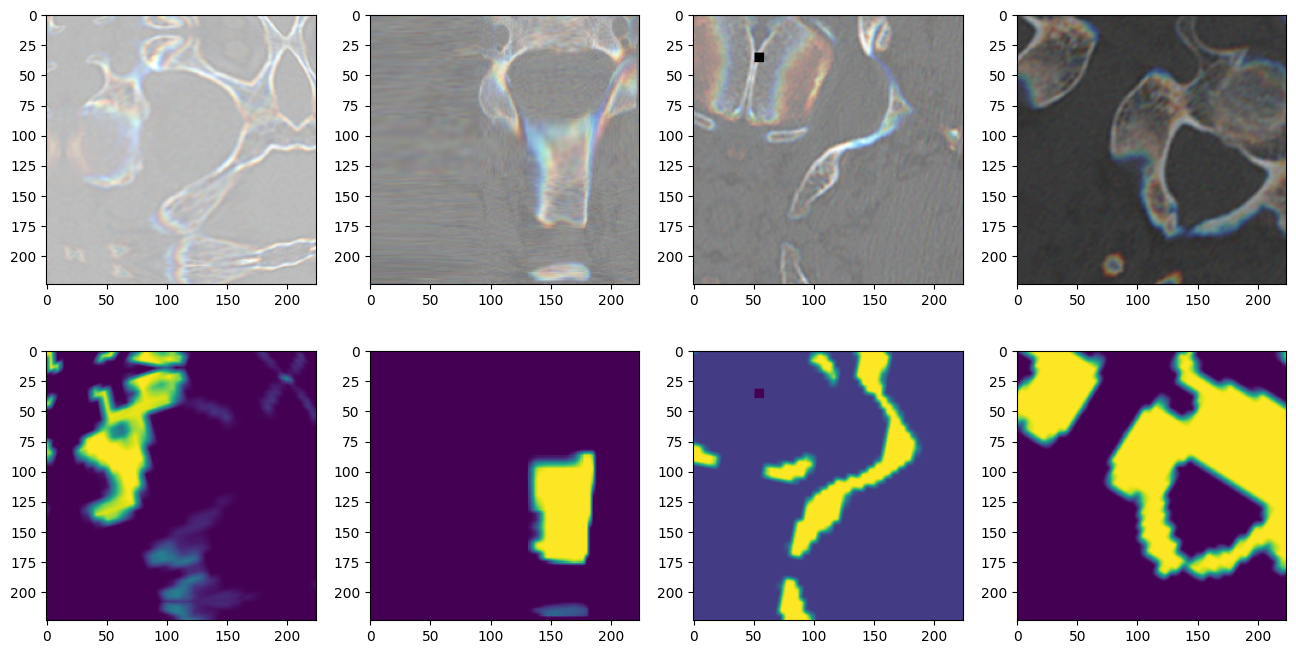

In [9]:
rcParams['figure.figsize'] = 16,8
f, axarr = plt.subplots(2,4)
for p in range(4):
    idx = p * 20
    imgs, lbl = dataset_show[idx]
    axarr[0, p].imshow(imgs[35][:3].permute(1, 2, 0))
    axarr[1, p].imshow(imgs[35][-1])

<h2>Models</h2>

In [10]:
lstm_hidden_size = 4  # Further reduced hidden size for LSTM
bottleneck_channels = 8  # Further reduced bottleneck layer channels

class TimmModelType2(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModelType2, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            features_only=True,  # We want the intermediate features, not the final classification layer
            pretrained=pretrained
        )

        if 'vgg' in backbone:
            hdim = 512 # The number of channels after the final conv layer
        elif 'convnext' in backbone:
            hdim = self.encoder.feature_info[-1]['num_chs']  # Get the number of channels in the last feature map
        else:
            raise ValueError(f"Backbone {backbone} not supported")

        # Add a bottleneck layer to reduce the number of channels
        self.bottleneck = nn.Conv2d(hdim, bottleneck_channels, kernel_size=1)  # Reduce to bottleneck_channels
        hdim = bottleneck_channels

        self.lstm = nn.LSTM(hdim * 7 * 7, lstm_hidden_size, num_layers=1, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(2 * lstm_hidden_size, 8),  # Further reduce fully connected layer size
            nn.BatchNorm1d(8),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(8, out_dim),
        )
        self.lstm2 = nn.LSTM(hdim * 7 * 7, lstm_hidden_size, num_layers=1, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head2 = nn.Sequential(
            nn.Linear(2 * lstm_hidden_size, 8),
            nn.BatchNorm1d(8),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(8, 1),
        )

    def forward(self, x):  # (bs, nc*7, ch, sz, sz)
        bs = x.shape[0]
        #print(f"Input shape: {x.shape}")

        x = x.view(bs * n_slice_per_c * 7, in_chans, image_size, image_size)
        #print(f"Shape after view: {x.shape}")

        feat = self.encoder(x)[-1]  # Get the last feature map
        #print(f"Shape after encoder features: {feat.shape}")

        # Apply the bottleneck layer
        feat = self.bottleneck(feat)
        #print(f"Shape after bottleneck: {feat.shape}")

        # Flatten the spatial dimensions
        feat = feat.view(feat.size(0), -1)  # This will be [bs * n_slice_per_c * 7, bottleneck_channels*7*7]

        # Reshape to [bs, n_slice_per_c * 7, bottleneck_channels*7*7]
        feat = feat.view(bs, n_slice_per_c * 7, -1)
        #print(f"Shape before LSTM: {feat.shape}")

        feat1, _ = self.lstm(feat)
        #print(f"Shape after LSTM feat1: {feat1.shape}")

        feat1 = feat1.contiguous().view(bs * n_slice_per_c * 7, 2 * lstm_hidden_size)
        feat2, _ = self.lstm2(feat)
        #print(f"Shape after LSTM feat2: {feat2.shape}")

        return self.head(feat1), self.head2(feat2[:, 0])



In [11]:
# m = TimmModelType2(backbone)
total_params = sum(p.numel() for p in TimmModelType2(backbone).parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 14746186


<h2>Loss & Metric</h2>

In [12]:
bce = nn.BCEWithLogitsLoss(reduction='none')


def criterion(logits, targets, activated=False):
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 2.
    norm = torch.ones(logits.view(-1).shape[0]).to(device)
    norm[targets.view(-1) > 0] *= 2
    return losses.sum() / norm.sum()

<h2>Train & Valid func</h2>

In [13]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    train_loss1 = []
    train_loss2 = []
    bar = tqdm(loader_train)
    for images, targets in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        
        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, targets, targets_mix, lam = mixup(images, targets)

        with amp.autocast():
            logits, logits2 = model(images)
            loss1 = criterion(logits, targets)
            loss2 = criterion(logits2, targets.max(1).values)
            loss = (loss1 * lw[0] + loss2 * lw[1]) / sum(lw)
            if do_mixup:
                loss11 = criterion(logits, targets_mix)
                loss22 = criterion(logits2, targets_mix.max(1).values)
                loss = loss * lam  + (loss11 * lw[0] + loss22 * lw[1]) / sum(lw) * (1 - lam)
        train_loss1.append(loss1.item())
        train_loss2.append(loss2.item())
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss1[-30:]):.4f} {np.mean(train_loss2[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    valid_loss1 = []
    valid_loss2 = []
    outputs = []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets in bar:
            images = images.cuda()
            targets = targets.cuda()

            logits, logits2 = model(images)
            loss1 = criterion(logits, targets)
            loss2 = criterion(logits2, targets.max(1).values)
            loss = (loss1 + loss2) / 2.
            valid_loss1.append(loss1.item())
            valid_loss2.append(loss2.item())
            valid_loss.append(loss.item())
            bar.set_description(f'smth:{np.mean(valid_loss1[-30:]):.4f} {np.mean(valid_loss2[-30:]):.4f}')

    return np.mean(valid_loss)

In [14]:
# rcParams['figure.figsize'] = 20, 2
# optimizer = optim.AdamW(m.parameters(), lr=init_lr)
# scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

# lrs = []
# for epoch in range(1, n_epochs+1):
#     scheduler_cosine.step(epoch-1)
#     lrs.append(optimizer.param_groups[0]["lr"])
# plt.plot(range(len(lrs)), lrs)

In [15]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmModelType2(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    from_epoch = 0
    metric_best = np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)
        if epoch < from_epoch + 1:
            print(logs[epoch-1])
            continue

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss = valid_func(model, loader_valid)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
#run(0)
#run(1)
run(2)
run(3)
run(4)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv features.0 pretrained weights from 3 to 6 channel(s)


1615 403
Fri May 17 17:34:17 2024 Epoch: 1


smth:0.6537 0.6372: 100%|██████████| 202/202 [05:07<00:00,  1.52s/it]


Fri May 17 18:12:32 2024 Fold 2, Epoch 1, lr: 0.0000230, train loss: 0.65651, valid loss: 0.65132, metric: 0.651317.
metric_best (inf --> 0.651317). Saving model ...
Fri May 17 18:12:33 2024 Epoch: 2


smth:0.5878 0.6983:  64%|██████▍   | 130/202 [03:02<01:40,  1.39s/it]